# DDPG algorithm in flax

In [3]:
import gymnasium as gym
import numpy as np
from collections import deque
import optax
import matplotlib.pyplot as plt
import time

import jax.tree_util as jtu
from jax import random
import jax.numpy as jnp
import jax

from flax.training import train_state, orbax_utils
from flax import linen as nn  # Linen API

from tqdm import tqdm
import orbax.checkpoint
import os

F_CPP_MIN_LOG_LEVEL=0

In [ ]:
ckpt_dir = a

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)

## Create necessary methods to the training

In [5]:
#random process N for action exploration
@jtu.Partial(jax.jit, static_argnums=2)
def noise(noise_scale=0.1, key=random.PRNGKey(0), action_dim=2):
    return noise_scale * jax.random.normal(key, (action_dim,))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
# Define the method to update model parameters

# update critic
@jax.jit
def update_critic(model, states, actions, y):
    def compute_critic_loss(params):
        Q = model.apply_fn(params, states, actions)
        
        return jnp.mean((Q - y)**2) #compute loss
    
    loss, grads = jax.value_and_grad(compute_critic_loss)(model.params)
    updated_model = model.apply_gradients(grads=grads)
   
    return updated_model, loss

# udate actor
@jtu.Partial(jax.jit, static_argnums=(2,))
def update_actor(model, states, action_dim):
    def compute_actor_loss(params):
        actions = model.apply_fn(params, states, action_dim)

        return -jnp.mean(actions)  # Compute the actor loss

    loss, grads = jax.value_and_grad(compute_actor_loss)(model.params)
    updated_model = model.apply_gradients(grads=grads)

    return updated_model, loss

# Define the soft update function
@jax.jit
def soft_update(target_params, source_params, tau):
    # Convert the source_params to a JAX-compatible data structure
    source_params_tree = jtu.tree_map(lambda x: jnp.asarray(x), source_params)
    target_params_tree = jtu.tree_map(lambda x: jnp.asarray(x), target_params)

    # Compute the updated target parameters using a soft update
    updated_params = jtu.tree_map(lambda x, y: tau * x + (1 - tau) * y,
                                  source_params_tree, target_params_tree)

    return updated_params

In [7]:
# define the replay buffer
class ReplayBuffer():
    def __init__(self, buffer_size, batch_size, key):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.buffer = deque(maxlen=self.buffer_size)
        self.key = key

    def add(self, transition):
        self.buffer.append(transition)

    def sample_batch(self):
        indices = jax.random.choice(self.key, len(self.buffer),
                                    shape=(self.batch_size,), replace=True)
        batch = [self.buffer[i] for i in indices]

        return zip(*batch)

## Create actor and critic model

In [8]:
#create the actor and critic newtorks like multilayer perceptrons
class Critic(nn.Module):
    """critic model MLP"""
    
    @nn.compact
    def __call__(self, observations, actions):
        x = jnp.concatenate([observations, actions], axis=-1)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return jnp.squeeze(x, axis=-1)
    
class Actor(nn.Module):
    """actor model MLP"""
    
    @nn.compact
    def __call__(self, x, action_dim):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=action_dim)(x)
        x = nn.tanh(x)
        return x

## Algorithm

In [9]:
# define environment and parameters
env = gym.make("InvertedPendulum-v4")
action_dim = env.action_space.shape[0]
state_dim = env.observation_space.shape[0]

#initialize parameters
seed = 0
key = random.PRNGKey(seed)
episodes = 2
gamma = 0.99 #discount factor 0:nearly rewards, 1:future rewards
tau = 0.995 #polyak between 0-1 updating target network
max_episode_steps = 500
buffer_size = 1000000 #memory size
batch_size = 100 #The number of experiences sampled from the replay buffer
learning_rate = 0.001
noise_scale = 0.1 #scale of the noise for random process N for action exploration

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=max_episode_steps)

In [14]:
# Randomly initialize critic network Q(s, a|θ_Q ) and actor μ(s|θ_μ ) with weights θ_Q and θ_μ .
critic_params = Critic().init(key,
                              jnp.zeros((1, state_dim)),
                              jnp.zeros((1, action_dim)))

actor_params = Actor().init(key, jnp.zeros((1, state_dim)), action_dim)

# define optimizers
actor_optimizer = optax.adam(learning_rate=learning_rate)
actor_opt_state = actor_optimizer.init(actor_params)

critic_optimizer = optax.adam(learning_rate=learning_rate)
critic_opt_state = critic_optimizer.init(critic_params)

# Initialize the training state for flax porpuses
critic = train_state.TrainState.create(
    apply_fn=Critic().apply,
    params=critic_params,
    tx=critic_optimizer
)

actor = train_state.TrainState.create(
    apply_fn=Actor().apply,
    params=actor_params,
    tx=actor_optimizer,
)

# to save agent
config = {'dimensions': jnp.array([5,3]), 'name': 'actor'}
ckpt = {'model': actor, 'config': config, 'data': actor_params}

# print(Actor().tabulate(key, (1, state_dim), action_dim))
# print(Critic().tabulate(key, jnp.ones((1,action_dim)), jnp.ones((1,state_dim))))

In [15]:
# Initialize target network Q_0_target and μ_0_target with weights 
# θ_Q_target ← θ_Q , θ_μ_target ← θ_μ

target_critic_params = critic_params
target_actor_params = actor_params

# Initialize the training state for flax porpuses
target_critic = train_state.TrainState.create(
    apply_fn=Critic().apply,
    params=target_critic_params,
    tx=critic_optimizer
)

target_actor = train_state.TrainState.create(
    apply_fn=Actor().apply,
    params=target_actor_params,
    tx=actor_optimizer
)

In [16]:
# Initialize replay buffer R
buffer = ReplayBuffer(buffer_size, batch_size, key)

In [18]:
#train loop
episodes_reward = []
critic_loss = 0
actor_loss = 0
start_time = time.time()

for i in tqdm(range(episodes)):
    # Initialize a random process N for action exploration
    N = noise(noise_scale, key, action_dim)
    # Receive initial observation state s 1
    state, info = env.reset(seed=seed)
    done = False

    while not done:
        # Select action a_t = μ(s t |θ μ ) + N t according to the current policy and exploration noise
        action = actor.apply_fn(actor.params, state, action_dim) + N

        # Execute action a t and observe reward r t and observe new state s t+1
        observation, reward, terminated, truncated, info = env.step(action)
        
        # Store transition (s t , a t , r t , s t+1 ) in R
        transition = (state, action, reward, observation)
        
        # buffer.append(transition)
        buffer.add(transition)

        # Sample a random minibatch of N transitions (s i , a i , r i , s i+1 ) from R
        states, actions, rewards, next_states = buffer.sample_batch()

        # Set y = r  + γQ^0 (s_{i+1} , μ^0 (s_{i+1} |θ^μ )|θ^Q ) P
        target_action = target_actor.apply_fn(target_actor_params,
                                              jnp.asarray(next_states, dtype=jnp.float16),
                                              action_dim)
        
        target_q = target_critic.apply_fn(target_critic_params,
                                          jnp.asarray(next_states, dtype=jnp.float16),
                                          jnp.asarray(target_action, dtype=jnp.float16))

        y = reward + gamma * (1 - terminated) * target_q

        # Update critic by minimizing the loss
        critic, critic_loss = update_critic(critic,
                                            jnp.asarray(states, dtype=jnp.float16),
                                            jnp.asarray(actions, dtype=jnp.float16),
                                            jnp.asarray(y, dtype=jnp.float16))

        # Update the actor policy using the sampled gradient:
        actor, actor_loss = update_actor(actor,
                                         jnp.asarray(states,dtype=jnp.float16),
                                         action_dim)

        # Update the target networks:
        target_actor_params = soft_update(target_actor_params, actor.params, tau)
        target_critic_params = soft_update(target_critic_params, critic.params, tau)
       
        # update if the environment is done and the current observation
        done = terminated or truncated

    episodes_reward.append(env.return_queue[-1]) 
    avg_reward = int(np.mean(env.return_queue))
    
    print("Episode:", i+1, "\n")
    print("reward:", env.return_queue[-1])
    print("Average reward:", avg_reward)
    print("Critic loss:", critic_loss)
    print("Actor loss:", actor_loss)

env.close()

# save agent
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('./agent', ckpt, save_args=save_args)

print(ckpt)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time)

 50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 1/2 [00:00<00:00,  1.45it/s]

Episode: 1 

reward: [5.]
Average reward: 9
Critic loss: 6.8613806
Actor loss: -0.64706254


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.33it/s]

Episode: 2 

reward: [5.]
Average reward: 8
Critic loss: 27.30974
Actor loss: -0.8032522


ValueError: Destination agent already exists.

## Visualizing the training

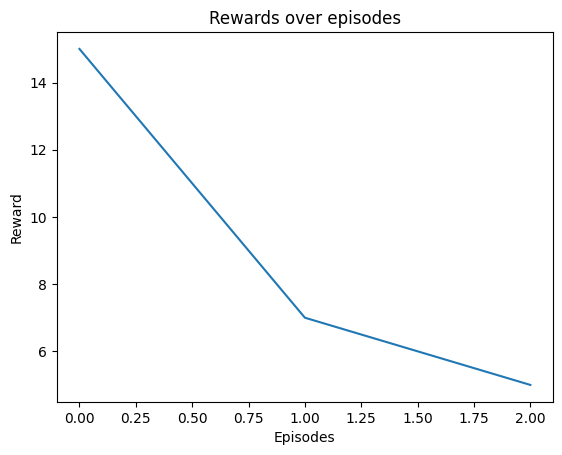

In [28]:
rewards_to_plot = [rewards for rewards in episodes_reward]

plt.plot(range(episodes), episodes_reward)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards over episodes')
plt.show()